In [30]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [31]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../../data/benchmark-cluster/explodingLiquid/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        thread = directory.split("/")[-2]
        scenario = directory.split("/")[-3]

        with open(os.path.join(directory, file)) as f:
            print(directory, file)
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not tuning_algorithm in data[scenario][thread]:
            data[scenario][thread][tuning_algorithm] = {}

        data[scenario][thread][tuning_algorithm][file_type] = df_tuners

Processing AutoPas_tuningResults_Rank0_2024-06-14_15-43-56.csv
../../../../data/benchmark-cluster/explodingLiquid/12/BayesianClusterSearch AutoPas_tuningResults_Rank0_2024-06-14_15-43-56.csv
Processing AutoPas_tuningData_Rank0_2024-06-14_15-43-56.csv
../../../../data/benchmark-cluster/explodingLiquid/12/BayesianClusterSearch AutoPas_tuningData_Rank0_2024-06-14_15-43-56.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-14_15-43-56.csv
../../../../data/benchmark-cluster/explodingLiquid/12/BayesianClusterSearch AutoPas_iterationPerformance_Rank0_2024-06-14_15-43-56.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-15_18-04-35.csv
../../../../data/benchmark-cluster/explodingLiquid/12/FuzzyTuning [Individual] AutoPas_iterationPerformance_Rank0_2024-06-15_18-04-35.csv
Processing AutoPas_tuningResults_Rank0_2024-06-15_18-04-35.csv
../../../../data/benchmark-cluster/explodingLiquid/12/FuzzyTuning [Individual] AutoPas_tuningResults_Rank0_2024-06-15_18-04-35.csv
Processing AutoPa

# Make Line Plot of Smoothed Value over Iterations


3.3682769236730277
2.927344601783185
2.7087376126989415
2.634741993000583
2.4878700736605284
1.6925907976002
1.384627766186151


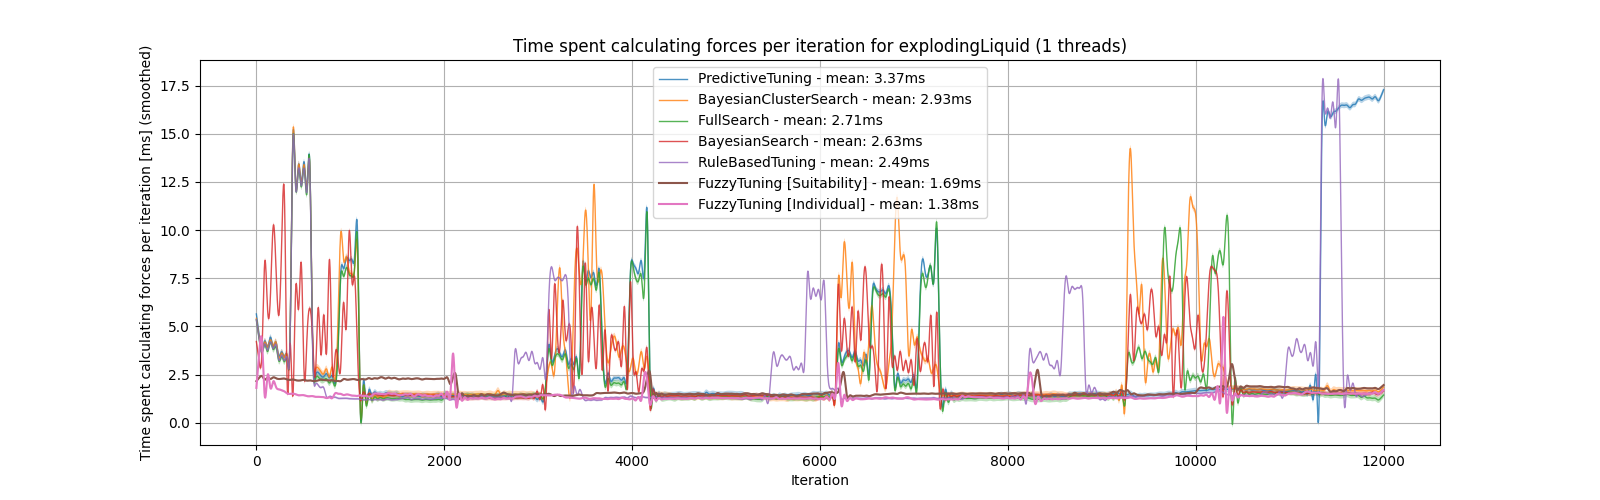

3.410780637280227
3.168244675360387
3.0955176075327056
2.943643884759604
2.9121489005916175
2.0478259704191317
1.9045749674193817


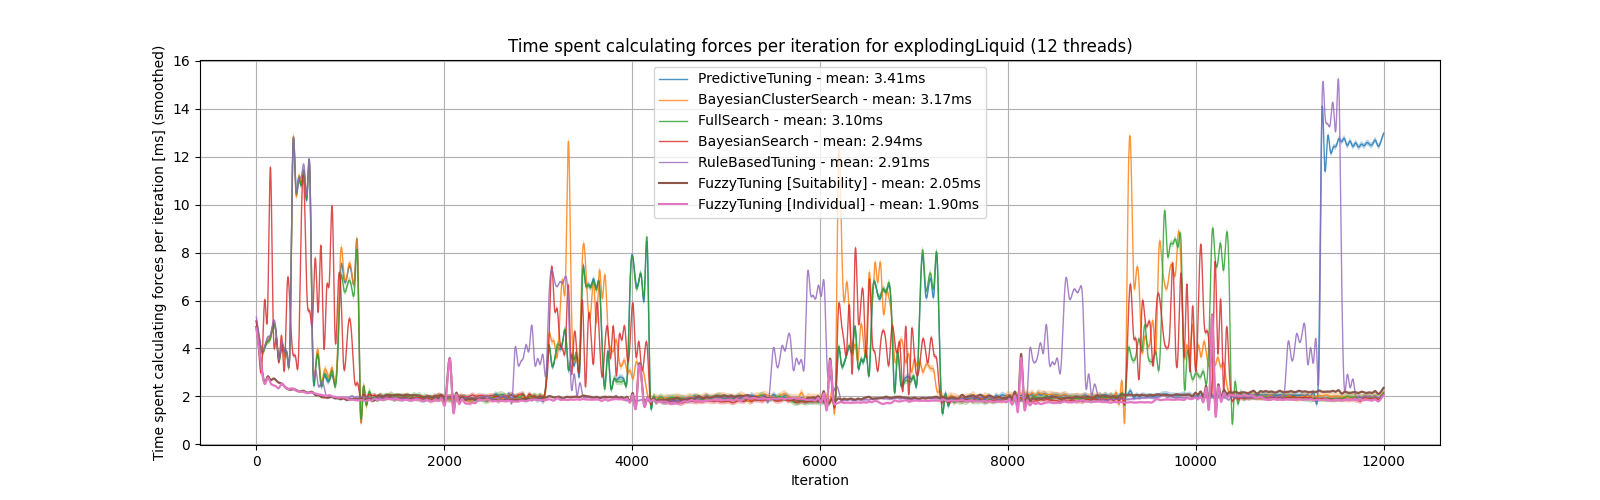

5.053583832763936
4.830223586534456
4.829050498875094
4.704005324389634
4.534660127322723
3.664179663778019
3.2978992238980083


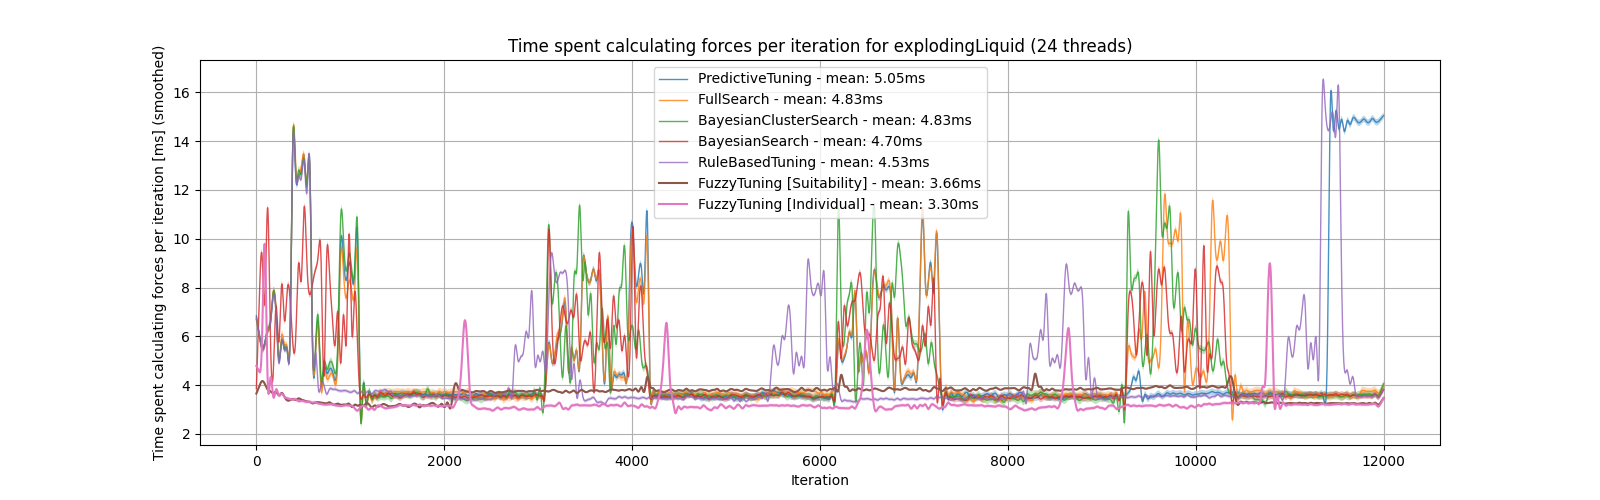

5.542091252395633
5.1340088470127485
5.132643746521124
4.789230667694359
4.687260191067411
4.594029593533873
4.422388565786184


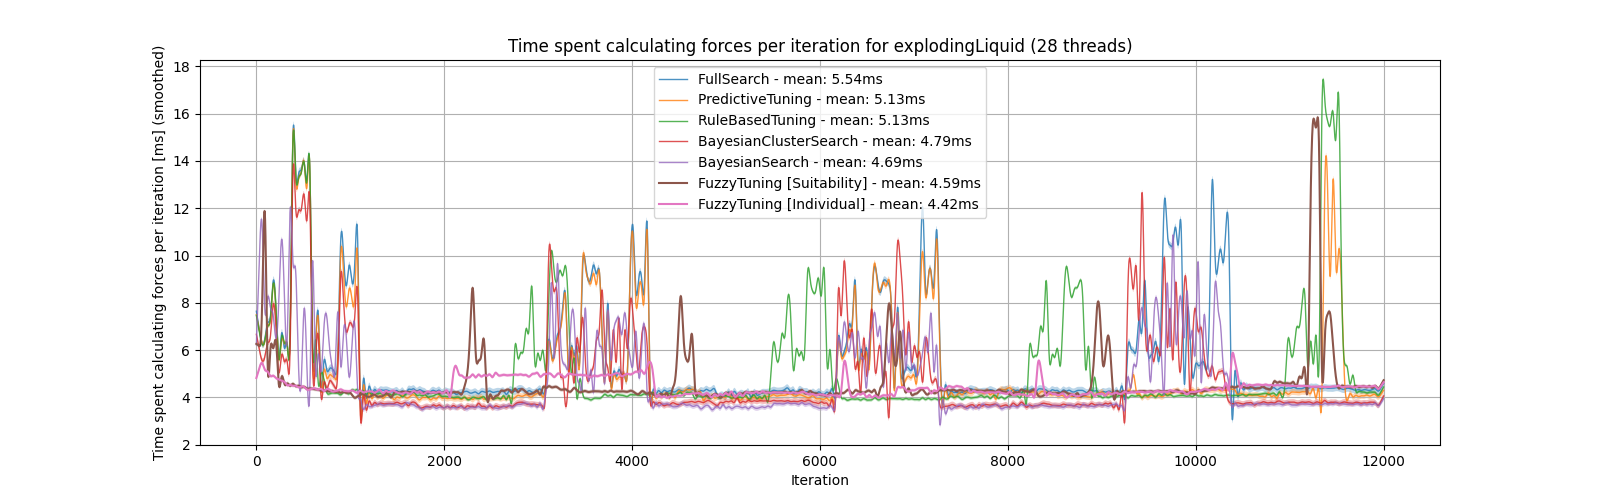

In [39]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items()):
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):

            iteration_data = logs["iterationPerformance"]

            time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

            first_k = 1000000

            x = iteration_data["Iteration"][:first_k]
            y = time_s[:first_k] * 1000

            mean = y.mean()

            print(mean)

            # ax.plot(x, y, label=f"{tuning_algorithm} - mean: {meanNS:.2f}ns")

            if np.logical_or(np.isnan(y), np.isinf(y)).any():
                print(y)
                raise ValueError(f"Found NaN or Inf in {
                                 tuning_algorithm + threads + scenario}")

            n = int(len(y)/30)

            smoother = SplineSmoother(n_knots=n, spline_type="natural_cubic_spline")
            smoother.smooth(y)

            low, up = smoother.get_intervals('sigma_interval', n_sigma=0.04)

            linewidth = 1.5 if "Fuzzy" in tuning_algorithm else 1
            opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8

            ax.plot(smoother.smooth_data[0], label=f"{
                    tuning_algorithm} - mean: {mean:.2f}ms", linewidth=linewidth, alpha=opacity)

            plt.fill_between(
                range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

        ax.legend()
        ax.set_xlabel("Iteration")
        ax.set_ylabel(
            "Time spent calculating forces per iteration [ms] (smoothed)")

        # set y axis to mikro seconds

        ax.set_title(f"Time spent calculating forces per iteration for {
                     scenario} ({threads} threads)")
        # ax.set_xlim(0, df["Iteration"].max())
        # log
        ax.grid()
        plt.show()

# Make bar plots about total time

12001
FuzzyTuning [Individual] - 16.616917822
FuzzyTuning [Suitability] - 20.312782162
RuleBasedTuning - 29.856928754
BayesianSearch - 31.619538658
FullSearch - 32.50756009
BayesianClusterSearch - 35.131062566
PredictiveTuning - 40.422691361


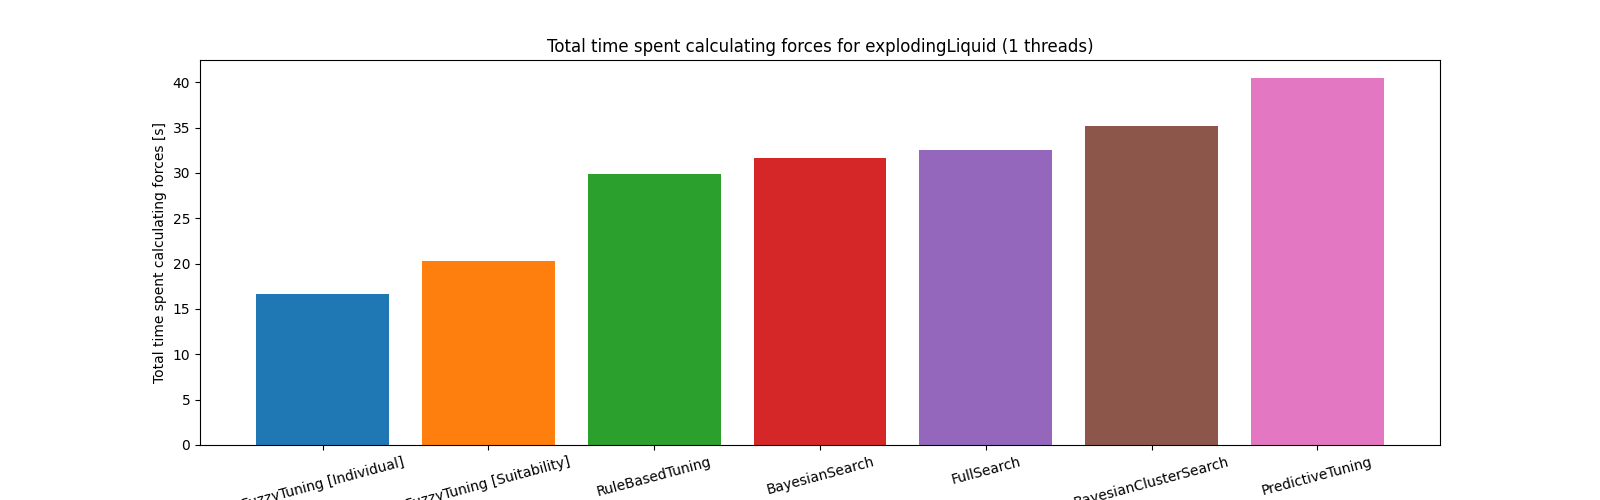

FuzzyTuning [Individual] - 22.856804184
FuzzyTuning [Suitability] - 24.575959471
RuleBasedTuning - 34.948698956
BayesianSearch - 35.326670261
FullSearch - 37.149306808
BayesianClusterSearch - 38.022104349
PredictiveTuning - 40.932778428


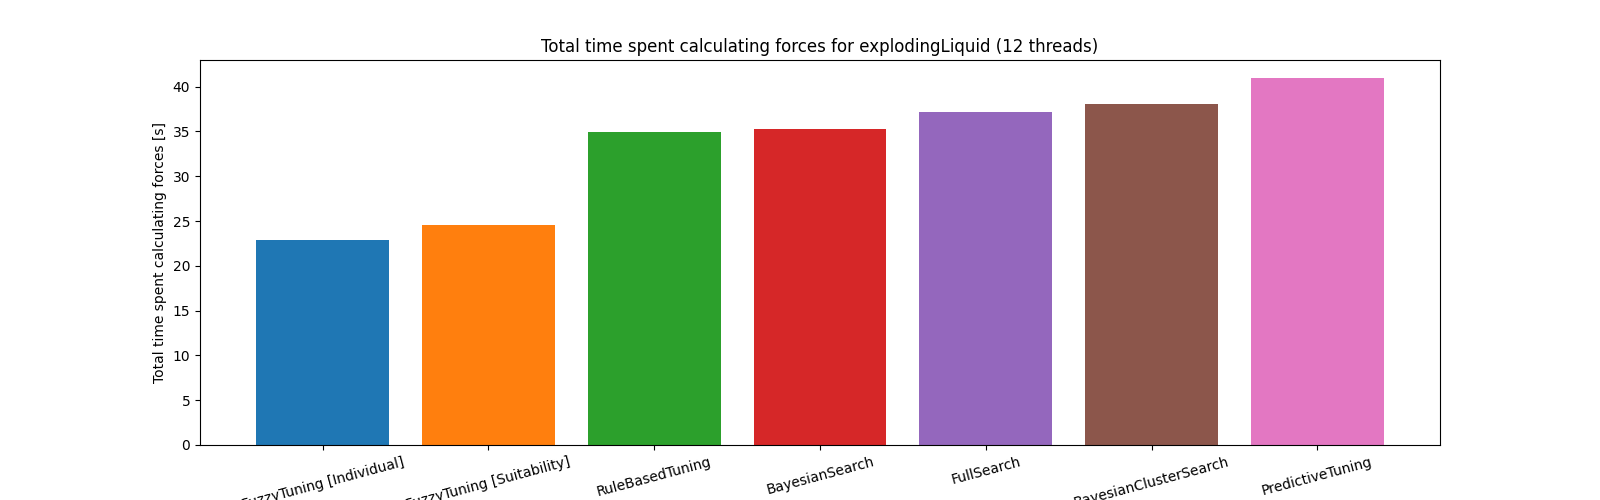

FuzzyTuning [Individual] - 39.578088586
FuzzyTuning [Suitability] - 43.973820145
RuleBasedTuning - 54.420456188
BayesianSearch - 56.452767898
BayesianClusterSearch - 57.953435037
FullSearch - 57.967513262
PredictiveTuning - 60.648059577


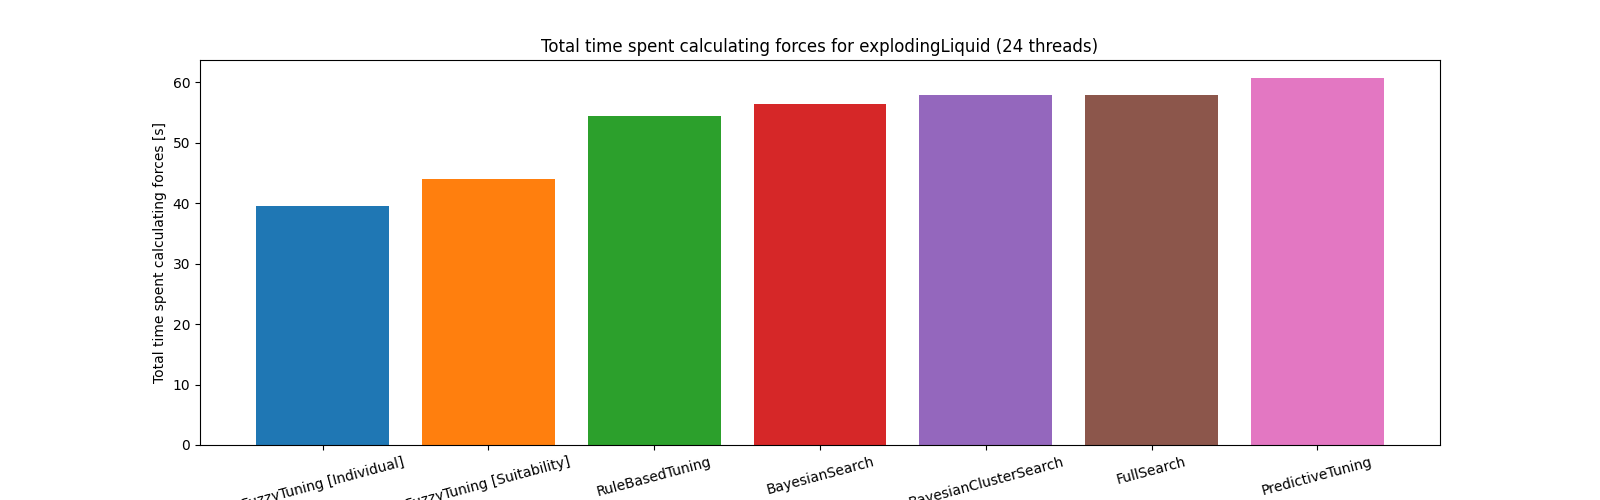

FuzzyTuning [Individual] - 53.073085178
FuzzyTuning [Suitability] - 55.132949152
BayesianSearch - 56.251809553
BayesianClusterSearch - 57.475557243
RuleBasedTuning - 61.596857602
PredictiveTuning - 61.613240173
FullSearch - 66.51063712


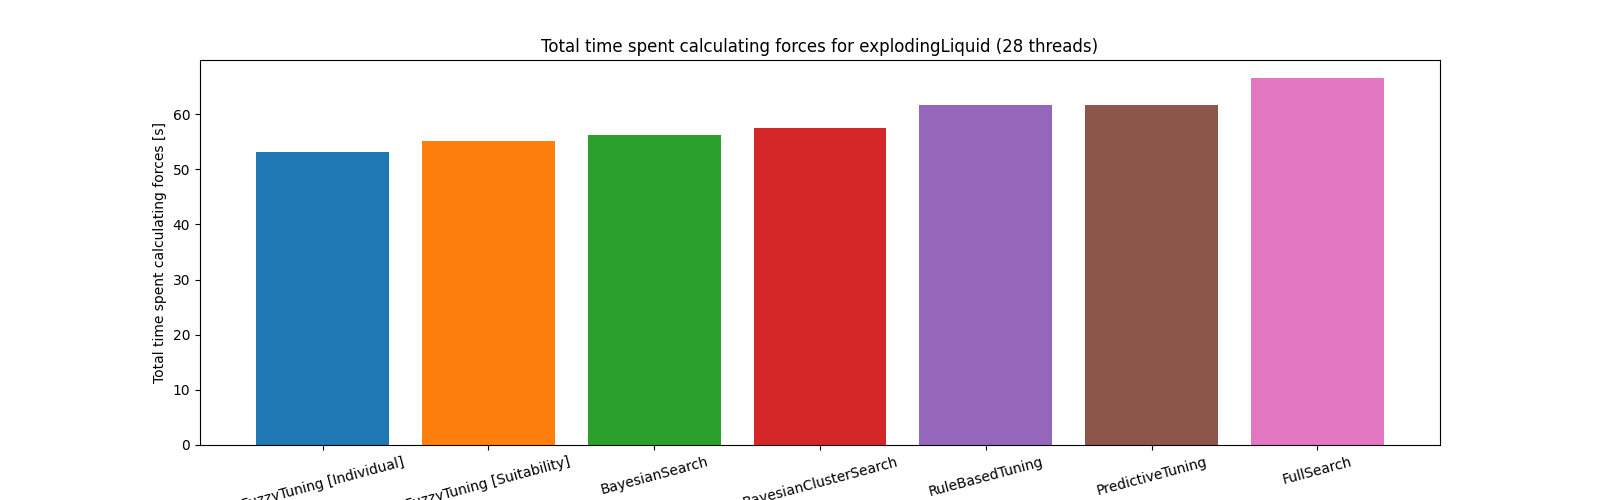

In [40]:
longest_simulation = 0
for scenario, s_data in data.items():

    for threads, r_data in s_data.items():

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

            longest_simulation = max(
                longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)


for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items(), key=lambda x: x[0]):
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):

            iteration_data = logs["iterationPerformance"]

            completness = len(iteration_data) / longest_simulation

            total_time_s = iteration_data["iteratePairwiseTotal[ns]"].sum(
            ) / 1e9

            total_time_s = total_time_s / completness

            print(f"{tuning_algorithm} - {total_time_s}")

            ax.bar(tuning_algorithm, total_time_s, label=f"{tuning_algorithm}")

        # tilt x labels
        plt.xticks(rotation=15)

        ax.set_ylabel("Total time spent calculating forces [s]")

        ax.set_title(f"Total time spent calculating forces for {scenario} ({threads} threads)")

        plt.show()